# Interactive Nestle Demo

This is a simple interactive demo (following the [example](http://kylebarbary.com/nestle/examples/plot_shells.html#sphx-glr-examples-plot-shells-py) in the documentation) that briefly goes over nested sampling and some of the features available in `Nestle`. Many of the features demonstrated here were developed specifically for Prospector.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import concurrent
from collections import OrderedDict

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Nested Sampling: Background

In standard Bayesian inference, we are interested in estimating the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ of a set of **parameters** $\boldsymbol{\Theta}$ for a given **model** $M$ given some **data** $\mathbf{D}$. This can be factored into a form known as **Bayes' Rule** to give

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)}$$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

Nested sampling attempts to estimate $\mathcal{Z}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the **prior volume** $X(\lambda)$ contained within **iso-likelihood contours** at $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$. More formally, defining the prior volume as

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

the evidence is just

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. In other words, if we could evaluate the iso-likelihood contour $\mathcal{L}_i \equiv \mathcal{L}(X_i)$ associated with a bunch of samples from the prior volume $0 < X_N < \dots < X_i < \dots < X_1 < X_0 < 1$, we can compute the evidence using standard numerical integration techniques (e.g., the trapezoid rule). Computing the evidence using these "nested shells" is what gives nested sampling its name.

## Nested Sampling: How It Works

We start with a number of $K$ **"live" points** drawn from the prior $\pi(\boldsymbol{\Theta})$. At each iteration $i$, we then remove the live point with the lowest likelihood $\mathcal{L}_i$ and corresponding prior volume $X_i$ and replace it with a new live point sampled from the prior subject to the constraint $\mathcal{L}_{i+1} > \mathcal{L}_i$. It can be shown through some neat statistical arguments (which we'll return to later) that this sampling procedure actually allows us to approximate the prior volume based on the current iteration as

$$ \ln X_i \approx -i/K $$

where we've ignored some uncertainties for clarity. Given that we compute $\mathcal{L}_i$ when moving to this live point in the first place, this actually enables us to directly estimate the evidence as using a set of $N$ samples via

$$ \mathcal{Z} \approx \hat{\mathcal{Z}} = \sum_{i=1}^{N} \mathcal{L}_i w_i $$

where $w_i = \Delta X_i$ is the associated weight. For a simple quadratic integration scheme, for instance, we can take $w_i = \frac{1}{2} (X_{i-1} - X_{i+1})$.

We can subsequently estimate posteriors "for free" by assigning each sample its associated **importance weight**

$$ P(\boldsymbol{\Theta}_i) \equiv p_i \approx \hat{p}_i = \frac{\mathcal{L}_i w_i}{\sum_{i=1}^{N} \mathcal{L}_i w_i} = \frac{\mathcal{L}_i w_i}{\hat{\mathcal{Z}}} \quad . $$

### Termination

The remaining prior volume $\Delta \mathcal{Z}_i$ can roughly be bounded by the maximum likelihood point contained within the live set $\mathcal{L}_{\max}$ multipled by the expected remaining prior volume $X_i$,

$$ \Delta \mathcal{Z}_i \approx \mathcal{L}_{\max} X_i \quad . $$

This error estimate often serves as a threshold that can be used for deciding when to terminate sampling.

### Sampling

The main requirements for nested sampling to work are:
1. that all samples used to compute/kill/replace live points are independent and
2. that all samples are drawn in proportion to the prior.

The first requirement is often not too difficult to satisfy. The second, however, is much harder to satisfy in cases where the prior is not uniform. Most nested sampling algorithms/packages (including `Nestle`) thus sample on the unit cube, which requires that you are able to transform your priors to be uniform (i.e. compute their inverse CDF).

Assuming that 1. and 2. are be satisfied, the main challenge of most nested sampling implementations is coming up with ways to draw a new point as uniformly as possible without spending too much time sampling outside the prior volume. These tend to break down into two schemes: random walking away from the current set of live points or attempting to enclose the prior volume contained by all live points. The latter tends to be more popular.

## Test Case: Gaussian Shells

Let's give `Nestle` a test run over a set of Gaussian shells.

In [22]:
import pnestle as nestle

In [28]:
# Gaussian shells likelihood

# circle/shell function
def logcirc(theta, c):
    d = sqrt(sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2) # log-circ

# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0.]) # location of shell 1
c2 = np.array([3.5, 0.]) # location of shell 2

We now need to define the transformation that takes our uniform samples and transforms them back to the variables of interest.

In [29]:
# prior transform
def prior_transform(x):
    """Defines a flat prior between -6 and 6 in all dimensions."""
    return 12. * x - 6.

Now let's run `Nestle`!

In [30]:
# nested sampling results
f = lambda theta: loglike(theta, c1, c2)
res = nestle.sample(f, prior_transform, 2, method='multi', npoints=1000)

Let's now plot our results.

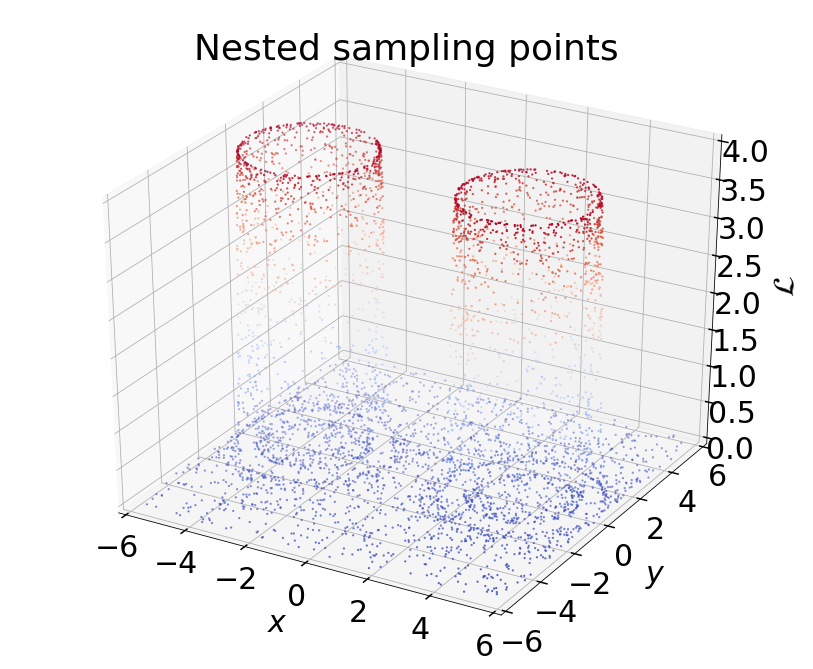

In [32]:
fig = figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(res.samples[:, 0], res.samples[:, 1], exp(res.logl),
           marker='.', c=exp(res.logl), linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-6., 6.)
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-6., 6.)
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(0., 4.)
ax.set_zlabel(r'$\mathcal{L}$', labelpad=25)
ax.set_title('Nested sampling points')
tight_layout()

Let's see how our performance scales with dimensionality here.

In [33]:
npoints = 1000

# run nestle for ndim Gaussian shells
def run(ndim):
    """Convenience function for running in any dimension"""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Ndim={0}...".format(ndim))
    return nestle.sample(f, prior_transform, ndim, method='multi', npoints=npoints)

In [8]:
dims = array([2, 5, 10, 20]) # dimensions to sample

# analytic log-evidence values
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59,
                 20: -36.09} 
                 #30: -60.13}
                 #50: -112.42}

# compute results
results = OrderedDict()
for ndim in dims:
    t0 = time.time()
    results[ndim] = run(ndim)
    results[ndim].time = time.time() - t0
sys.stdout.write("\n")

Ndim=2...Ndim=5...Ndim=10...Ndim=20...


Let's take a look at our results.

In [9]:
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in results.items():
    eff = 100. * res.niter / (res.ncall - npoints)
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz, res.logzerr,
                  res.ncall, eff, res.time))

D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.68     0.05   10838   40.50    1.43
 5    -5.67   -5.77     0.08   28097   29.78    4.26
10   -14.59  -14.77     0.12   50837   34.25    7.21
20   -36.09  -35.58     0.19  178293   21.36   31.64


## Parallelization

One of our changes to the default Nestle code is proposing points in parallel using `ThreadPoolExecutor`. This allows us to independently task a number of threads with finding good trial points that we can check as we go.

Parallelization works better when the likelihood calls are expensive and you're not guaranteed to accept the results, making it computationally more expedient to try a bunch of points rather than one at a time. We'll put this in by hand here.

In [10]:
# log-likelihood function
def loglike(theta, c1, c2):
    time.sleep(1e-3)
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

In [11]:
# run nestle for ndim Gaussian shells
def parallel_run(ndim, nthreads, pool):
    """Convenience function for running in any dimension with multiple threads."""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Nthreads={0}...".format(nthreads))
    return nestle.sample(f, prior_transform, ndim, method='multi', npoints=npoints, 
                         n_threads=nthreads, pool=pool)

In [12]:
threads = array([1, 2, 4, 8, 16])
ndim = 5
npoints = 1000

# compute results
results = OrderedDict()
for nthreads in threads:
    t0 = time.time()
    with concurrent.futures.ThreadPoolExecutor(nthreads) as pool:
        results[nthreads] = parallel_run(ndim, nthreads, pool)
    results[nthreads].time = time.time() - t0
sys.stdout.write("\n")

Nthreads=1...Nthreads=2...Nthreads=4...Nthreads=8...Nthreads=16...


Let's now see how we're doing.

 D  N  analytic    logz  logzerr   nlike  eff(%)   time
 5   1    -5.67   -5.53     0.08   23987   34.06   33.15
 5   2    -5.67   -5.67     0.08   23745   35.03   17.88
 5   4    -5.67   -5.69     0.08   23863   34.97   10.58
 5   8    -5.67   -5.54     0.08   23006   35.64    7.34
 5  16    -5.67   -5.73     0.08   26880   31.03    7.86


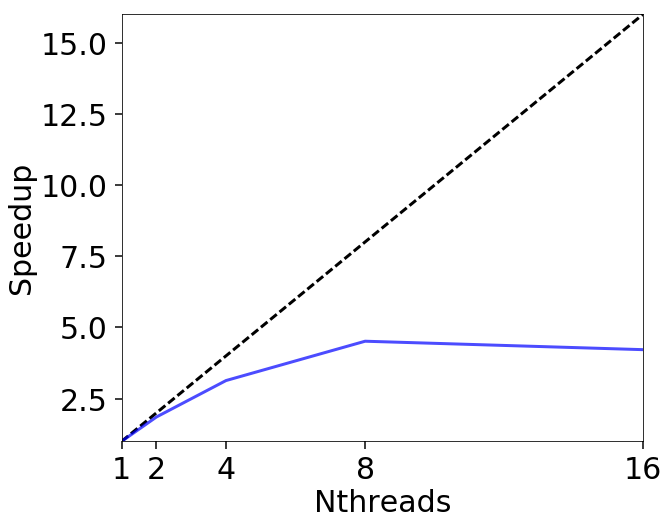

In [13]:
print(" D  N  analytic    logz  logzerr   nlike  eff(%)   time")
for nthreads, res in results.items():
    eff = 100. * res.niter / (res.ncall - npoints)
    print("{:2d}  {:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, nthreads, analytic_logz[ndim], res.logz, res.logzerr,
                  res.ncall, eff, res.time))
    
times = array([res.time for nthreads, res in results.items()])
speedup = times[0] / times

figure(figsize=(10,8))
plot([1, max(threads)], [1, max(threads)], color='black', ls='--', lw=3)
plot(threads, speedup, color='blue', lw=3, alpha=0.7)
xlim([1, max(threads)])
ylim([1, max(threads)])
xlabel('Nthreads')
xticks(threads)
ylabel('Speedup')
tight_layout()

The falloff at $N>4$ cores here is specific to the machine I'm running these tests on, which only has 4 cores.

## Deriving Uncertainties from a Single Run

The particular statistical properties of nested sampling allow us to derive meaningful uncertainty estimates on our resulting evidence (and posteriors) using a single run. We'll go into some of the details of this below.

### Order Statistics

Nested sampling works in theory thanks to the magic of **order statistics**. At the start of our run, we sample $K$ points from the prior with likelihoods $\lbrace \mathcal{L}_1,\dots,\mathcal{L}_{K} \rbrace$ and associated prior volumes $ \lbrace X_1,\dots,X_K \rbrace$. We then want to pick the point with the maximum likelihood $\mathcal{L}_{(K)}$ out of the ordered set $\lbrace \mathcal{L}_{(1)},\dots,\mathcal{L}_{(K)} \rbrace$ with corresponding prior volume $X_{(K)}$ out of the ordered set $\lbrace X_{(1)},\dots,X_{(K)} \rbrace$. 

What is this prior volume? Well, all the points were drawn from the prior, so by the **probability integral transform (PIT)** the corresponding prior volumes are uniformly distributed **random variables** such that

$$ X_1,\dots,X_K \stackrel{i.i.d.}{\sim} \textrm{Unif} $$

where $\textrm{Unif}$ is the standard uniform distribution. It can be shown that the set of *ordered* uniformly distributed random variables (here our prior volumes) can be *jointly* represented by $K+1$ exponential random variables

$$ X_{(j)} \sim \frac{Y_1 + \cdots + Y_j}{Y_1 + \cdots + Y_{K+1}} \quad , \quad Y_1,\dots,Y_{K+1} \stackrel{i.i.d.}{\sim} \textrm{Expo} $$

where $\textrm{Expo}$ is the standard Exponential distribution.

### Prior Volumes

We are interested in the marginal distribution of $X_{(K)}$ associated with $\mathcal{L}_{(K)}, since that's the prior volume we are first sampling within. This turns out to be

$$ X_{(j=K)} \sim \textrm{Beta}(j,K-j+1) = \textrm{Beta}(K,1) $$

where $\textrm{Beta}(\alpha,\beta)$ is the Beta distribution.

Once we replace a live point with a new live point that satisfies this constraint, we now want to do the same procedure again. Using the same logic as above, we know that our prior volumes must be i.i.d. uniformly distributed *within the previous volume* (since we just replace the worst point with a new independent draw). At a given iteration $i$ where we just replaced point $i-1$ with prior volume $X_{i-1}$, the prior volume associated with a new $X_i$ we're now trying to remove is then

$$ X_i \sim t_i X_{i-1} ~,~ t_i \sim \textrm{Beta}(K,1) \quad \Rightarrow \quad X_i \sim \prod_{j=1}^{i} t_j ~,~ t_1,\dots,t_i \stackrel{i.i.d.}{\sim} \textrm{Beta}(K,1) \quad \Rightarrow \quad \ln X_i = \sum_{j=1}^{i} \ln t_i \quad . $$

Once the algorithm terminantes after $N$ iterations using some stopping criteria, we are then left with a set of $K$ live points and a final set of $\lbrace X_{N+1}=X_{(1)}, \dots, X_{N+K}=X_{(K)} \rbrace$ prior volumes. Going back to our earlier results from order statistics, we can jointly represent the ratio of their volumes with respect to $X_N$ as

$$ \frac{X_{N+j}}{X_N} \sim \frac{Y_1 + \cdots + Y_{K-j+1}}{Y_1 + \dots + Y_{K+1}} \quad . $$

### Error Estimation

One of the most immediate consequences of the above derivation is that our evidence estimate $\hat{\mathcal{Z}} = \sum_{i=1}^{N} \mathcal{L}_i w_i$ and importance weights $\hat{p}_i = \frac{\mathcal{L}_i w_i}{\hat{\mathcal{Z}}}$ are both random variables *with defined distributions*. This means we can (in theory) actually compute marginal/joint errors on them from a single interation!

#### Typical Implementation

Since we're probing many points during a nested sampling run, most nested sampling implementations roughly approximate the evidence distribution using the first two (geometric) moments 

$$ E[\ln X_i] = \sum_{j=1}^{i} E[\ln t_i] = \sum_{j=1}^{i} -1/K = -i/K \quad , \quad \textrm{Var}[\ln X_i] = \sum_{j=1}^{i} \textrm{Var}[\ln t_i] = \sum_{j=1}^{i} 1/K = i/K $$

giving us 

$$ \ln X_i \approx \left. - \left(i \pm \sqrt{i}\right) \middle/ K \right. \quad . $$

By linearity of expectation, we then find for our quadratic weights

$$ E[\hat{\mathcal{Z}}] = \sum_{i=1}^{N} \mathcal{L}_i E[w_i] = \sum_{i=1}^{N} \mathcal{L}_i \, \frac{1}{2} \left( E[X_{i-1}] - E[X_{i+1}] \right) \approx \sum_{i=1}^{N} \, \frac{1}{2} \left( \mathcal{L}_i e^{E[\ln X_{i-1}]} - e^{E[\ln X_{i+1}]} \right) = \sum_{i=1}^{N} \mathcal{L}_i \, \frac{1}{2} \left( e^{-(i-1)/K} - e^{-(i+1)/K} \right) \quad . $$

A similar argument can be used to derive the approximate variance

$$ \textrm{Var}[\hat{\mathcal{Z}}] \approx \sum_{i=1}^{N} \mathcal{L}_i \, \frac{1}{2} \left( e^{(i-1)/K} + e^{(i+1)/K} \right) \quad . $$

The first moment of the importance weights used to compute the posterior is then often approximated as

$$ E[\hat{p}_i] \approx \frac{\mathcal{L}_i E[w_i]}{E[\hat{\mathcal{Z}}]} \quad . $$

Second moments are often not computed.

Finally, most implementations either do not use the last set of $K$ samples or add them to the evidence using crude approximations such as $X_{N+1} \approx \cdots \approx X_{N+K} \approx e^{-N/K} / K$. 

#### Sampling from the Full Error Distribution

As shown above, it is entirely possible to draw samples of $\lbrace X_1, \dots, X_N, X_{N+1}, \dots, X_{N+K} \rbrace$ directly. We can do this in two steps:

1. Draw a set of $N$ and $K+1$ random numbers as

$$ t_1, \dots, t_N \stackrel{i.i.d.}{\sim} \textrm{Beta}(K,1) \quad , \quad Y_1, \dots, Y_{K+1} \stackrel{i.i.d.}{\sim} \textrm{Expo} \quad . $$

2. Assign the corresponding $N+K+1$ prior volume samples as

$$ \ln X_j = \sum_{i=1}^{j} \ln t_j ~\forall~ j \leq N \quad , \quad X_{N+j} = \frac{\sum_{i=1}^{K-j+1} Y_i}{\sum_{i=1}^{K+1} Y_i} ~\forall~ j \leq K \quad . $$

Since these are actual samples, we can then just compute the realization of $\hat{Z}$ and $\lbrace \hat{p}_1, \dots, \hat{p}_{N+K+1} \rbrace$ directly.